## Misinformation Prediction

### Importing Libraries

In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import datasets
import string
import seaborn as sns

from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, Trainer
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from sklearn.metrics import f1_score
from huggingface_hub import notebook_login

In [2]:
# login to hugging face
notebook_login()

In [3]:
os.environ["WANDB_DISABLED"] = "false"

### Load the Datasets

In [4]:
data_fake = pd.read_csv('../data/Fake.csv')
data_true = pd.read_csv('../data/True.csv')

In [5]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Feature Engineering

In [7]:
# include a base column
data_fake['class'] = 0
data_true['class'] = 1

In [8]:
data_fake.shape, data_true.shape

((23481, 5), (21417, 5))

In [9]:
# check for missing values
data_true.isnull().sum()
data_fake.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

In [10]:
data_fake_manual_testing = data_fake.tail(10)
for i in range(23480, 23470, -1):
    data_fake.drop([i], axis=0, inplace=True)

data_true_manual_testing = data_true.tail(10)
for i in range(21416, 21406, -1):
    data_true.drop([i], axis=0, inplace=True)

In [11]:
data_fake_manual_testing['class'] = 0
data_true_manual_testing['class'] = 1

/tmp/ipykernel_5576/277247672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fake_manual_testing['class'] = 0
/tmp/ipykernel_5576/277247672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_true_manual_testing['class'] = 1


In [12]:
data_fake_manual_testing.head()

,title,text,subject,date,class
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0


In [13]:
data_true_manual_testing.head()

,title,text,subject,date,class
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1
21411,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",1


In [14]:
# merge the two data set true and fake
data_merge = pd.concat([data_fake, data_true], axis=0)
data_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [15]:
data_merge.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [16]:
data = data_merge.drop(['title', 'subject', 'date'], axis=1)

In [17]:
data.isnull().sum()

text     0
class    0
dtype: int64

In [18]:
data = data.sample(frac=1)

In [19]:
data.head(10)

,text,class
3105,Donald Trump has decided to throw out 60 years...,0
16150,The weaponization of the security services is ...,0
2877,Donald Trump is apparently so upset about his ...,0
5387,If Chris Christie is looking for his testicles...,0
525,WASHINGTON (Reuters) - A federal court in the ...,1
8525,NEW YORK (Reuters) - Democratic presidential n...,1
233,The following statements were posted to the ve...,1
19621,"NAYPYITAW, Myanmar/UNITED NATIONS (Reuters) - ...",1
10752,(Reuters) - Republican presidential front-runn...,1
22033,The events in Charlottesville have shaken the ...,0


In [20]:
# reset the index column
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

In [21]:
data.columns

Index(['text', 'class'], dtype='object')

In [22]:
data.head(9)

,text,class
0,Donald Trump has decided to throw out 60 years...,0
1,The weaponization of the security services is ...,0
2,Donald Trump is apparently so upset about his ...,0
3,If Chris Christie is looking for his testicles...,0
4,WASHINGTON (Reuters) - A federal court in the ...,1
5,NEW YORK (Reuters) - Democratic presidential n...,1
6,The following statements were posted to the ve...,1
7,"NAYPYITAW, Myanmar/UNITED NATIONS (Reuters) - ...",1
8,(Reuters) - Republican presidential front-runn...,1


<function matplotlib.pyplot.show(close=None, block=None)>

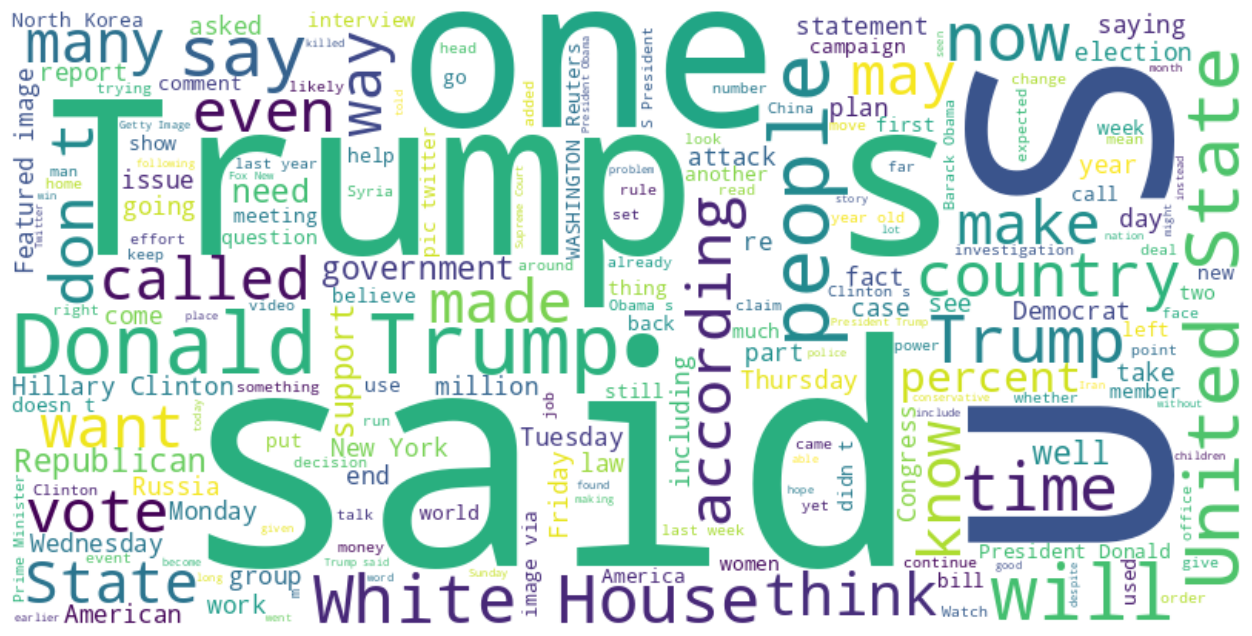

In [23]:
text = " ".join(text for text in data.text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color='white').generate_from_text(text)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show

In [24]:
def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\\W', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text_list = text.split()  # Convert the cleaned text to a list of words
    return text_list

In [25]:
data['text'] = data['text'].apply(wordopt)

In [26]:
train, eval = train_test_split(data, train_size=0.8, stratify=data['class'], random_state=42)

In [27]:
train.head(10)

,text,class
399,"[cairo, reuters, jordan, said, on, friday, a, ...",1
31094,"[moscow, reuters, russia, has, demanded, an, e...",1
19741,"[madrid, reuters, the, response, from, catalon...",1
8803,"[beirut, reuters, syrian, government, and, all...",1
9869,"[washington, reuters, a, bipartisan, pair, of,...",1
15273,"[reuters, presidentelect, donald, trump, said,...",1
33443,"[washington, reuters, the, united, states, mil...",1
19586,"[hillary, clinton, shocked, america, a, few, d...",0
18550,"[she, s, beautiful, classy, eloquent, and, she...",0
38691,"[reuters, legislation, approved, by, michigan,...",1


In [28]:
eval.head(10)

,text,class
7414,"[reuters, us, president, donald, trump’s, admi...",1
40983,"[united, nations, reuters, the, united, nation...",1
5142,"[the, video, below, is, unbelievable, in, its,...",0
42705,"[madonna, took, to, instagram, late, thursday,...",0
32873,"[dublin, reuters, a, breakthrough, on, the, fu...",1
38867,"[who, won, the, debate, tonight, donald, j, tr...",0
26785,"[if, you, re, keeping, track, so, far, donald,...",0
13427,"[donald, trump, s, team, certainly, doesn, t, ...",0
2913,"[abc, host, george, stephanopoulos, sat, down,...",0
9981,"[the, ammosexual, terrorists, currently, stagi...",0


In [29]:
train.to_csv('../data/train_subset.csv', index=False)
eval.to_csv('../data/eval_subset.csv', index=False)

In [30]:
datasets = load_dataset('csv',
                       data_files={'train':'../data/train_subset.csv',
                                   'eval':'../data/eval_subset.csv'
                       },
                        encoding = 'ISO-8859-1'
                       )

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [31]:
# Creating tokenizer Instance
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

/home/penscola/Project/Misinformation-Prediction/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
# Tokenization
def tokenize_data(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

# Function to transform class
def transform_class(data):
    label = data['class']
    leb = 'Legit' if label != 0 else 'Fake'
    return {'Label': leb}

In [33]:
# Tokenize text and transform original class
datasets = datasets.map(tokenize_data, batched=True)

Map:   0%|          | 0/35902 [00:00<?, ? examples/s]

Map:   0%|          | 0/8976 [00:00<?, ? examples/s]

In [34]:
# extract train and eval datasets from datasets
train_dataset=datasets['train'].shuffle(seed=0)
eval_dataset=datasets['eval'].shuffle(seed=0)

In [35]:
# define metric functions
def compute_metrics(evals_preds):
    logits, labels = evals_preds
    predictions = np.argmax(logits, axis=1)
    f1 = f1_score(labels=predictions, average='weighted')
    return {'f1_score': f1}

In [36]:
# set training arguments
trainargs = TrainingArguments(
    'roberta-news',
    num_train_epochs=5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    push_to_hub=True
    )

/home/penscola/Project/Misinformation-Prediction/.venv/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# Create an instance of the model
model_name = 'roberta-base'
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# create trainer instance
trainer = Trainer(
    model=model,
    args=trainargs,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [39]:
# start training
trainer.train()

  0%|          | 0/22440 [00:00<?, ?it/s]

: 